<a href="https://colab.research.google.com/github/DSabarish/netflix_data_analysis/blob/main/Netflix_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries and Data Quality Stats Function**

In [115]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Setting pandas options to display all columns and rows when printing dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# URL of the dataset to be read into a pandas dataframe
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv"
df = pd.read_csv(url)


In [116]:
def data_quality_statistics(df):
    """
    This function takes a DataFrame as input and returns a DataFrame containing data quality statistics
    for each column in the DataFrame.

    Args:
      df: A Pandas DataFrame.

    Returns:
      A DataFrame containing data quality statistics for each column.
    """

    # Number of rows in the DataFrame
    num_rows = len(df)

    # List to store statistics for each column
    stats = []

    # Iterate over columns
    for col in df.columns:
        # Number of unique values
        num_unique = df[col].nunique()

        # Number of NaN values
        num_nan = df[col].isnull().sum()

        # Percentage of NaN values
        pct_nan = (num_nan / num_rows) * 100

        # Data type of the column
        data_type = df[col].dtype

        # Append statistics to the list
        stats.append({
            'Column': col,
            'Number of Rows': num_rows,
            'Number of Unique Values': num_unique,
            'Number of NaN': num_nan,
            'Percentage of NaN': round(pct_nan, 2),
            'Data Type': data_type,
            # Add more statistics here if needed
        })

    # Convert list of dictionaries to DataFrame
    stats_df = pd.DataFrame(stats)

    return stats_df

# Example usage:
data_quality_statistics(df)


,Column,Number of Rows,Number of Unique Values,Number of NaN,Percentage of NaN,Data Type
0,show_id,8807,8807,0,0.00,object
1,type,8807,2,0,0.00,object
2,title,8807,8807,0,0.00,object
3,director,8807,4528,2634,29.91,object
4,cast,8807,7692,825,9.37,object
5,country,8807,748,831,9.44,object
6,date_added,8807,1767,10,0.11,object
7,release_year,8807,74,0,0.00,int64
8,rating,8807,17,4,0.05,object
9,duration,8807,220,3,0.03,object


# **Basis Cleaning**

In [117]:
# df.info()
# Observations from the dataframe information
# The dataset contains 8807 entries
# [date_added , release_year] need to be converted to datetime type


In [118]:
df = df.drop_duplicates(subset=df.columns, keep="first", inplace=False)
df.shape[0]

8807

In [119]:


# Remove leading and trailing spaces, extract only the date part, and convert to datetime format
df["date_added"] = (df["date_added"]
                    .astype(str)
                    .str.strip()
                    .apply(pd.to_datetime)
                    .dt.date
                    #.apply(pd.to_datetime)
                    )
df["date_added"].head(3)

# df["date_added"].describe()


0    2021-09-25
1    2021-09-24
2    2021-09-24
Name: date_added, dtype: object

In [120]:
df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."


In [121]:
# Convert "release_year" column to datetime format with the middle of the year
df["release_year"] = pd.to_datetime(df["release_year"].astype(str) + '-07-01')
# df["release_year"].head(3)

df["release_year"].describe()


count                             8807
mean     2014-09-04 23:07:11.247870976
min                1925-07-01 00:00:00
25%                2013-07-01 00:00:00
50%                2017-07-01 00:00:00
75%                2019-07-01 00:00:00
max                2021-07-01 00:00:00
Name: release_year, dtype: object

In [122]:
df[df["release_year"] == df["release_year"].min()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
4250,s4251,TV Show,Pioneers: First Women Filmmakers*,NaN,NaN,NaN,2018-12-30,1925-07-01,TV-14,1 Season,TV Shows,This collection restores films from women who ...


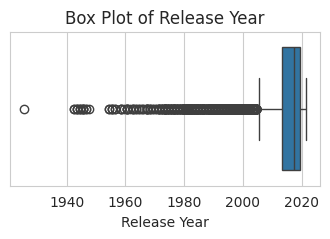

In [123]:
# Create the box plot
plt.figure(figsize=(4, 2))
sns.boxplot(x=df['release_year'])
plt.title('Box Plot of Release Year')
plt.xlabel('Release Year')
plt.show()


From the above dataframem we can see there are 5 features with null values. They are


1.   director
2.   cast
2.   country
2.   date_added
2.   rating

*  For director column, we can replace the null values with 'unknown'
*  For cast column, we can replace the null values with 'unknown'
*  For country column, we can replace null values with most frequent value (mode)
*  For date_added column, we can drop the rows with null values
*  For rating column, we can drop the null values.


# **1.1 Director**

In [124]:
# Create a copy of the DataFrame to work on
df_dir = df[["show_id", "title", "director"]].copy()
df_dir[:10]

# Specific check for the title "Scooby-Doo on Zombie Island"
df_dir[df_dir["title"] == "Scooby-Doo on Zombie Island"]

,show_id,title,director
7959,s7960,Scooby-Doo on Zombie Island,"Hiroshi Aoyama, Kazumi Fukushima, Jim Stenstrum"


In [125]:
# Function to replace 'nan' with pd.NA and split director names
def process_director(director):
    if isinstance(director, str) and director == 'nan':
        return [pd.NA]
    elif isinstance(director, str):
        return director.split(', ')
    else:
        return director  # If it's already a list or any other type

df_dir['director'] = df_dir['director'].apply(process_director)
exploded_dir_df = df_dir.explode('director').reset_index(drop=True)
exploded_dir_df[:10]

# Specific check for the title "Scooby-Doo on Zombie Island"
exploded_dir_df[exploded_dir_df['title'] == "Scooby-Doo on Zombie Island"]

,show_id,title,director
8657,s7960,Scooby-Doo on Zombie Island,Hiroshi Aoyama
8658,s7960,Scooby-Doo on Zombie Island,Kazumi Fukushima
8659,s7960,Scooby-Doo on Zombie Island,Jim Stenstrum


# **1.2 Cast**

In [126]:
# Create a copy of the DataFrame to work on
df_cast = df[["show_id", "title", "cast"]].copy()
df_cast[:10]

# Specific check for the title "Blood & Water"
df_cast[df_cast["title"] == "Blood & Water"]


,show_id,title,cast
1,s2,Blood & Water,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban..."


In [127]:
# Function to replace 'nan' with pd.NA and split cast names
def process_cast(cast):
    if isinstance(cast, str) and cast == 'nan':
        return [pd.NA]
    elif isinstance(cast, str):
        return cast.split(', ')
    else:
        return cast  # If it's already a list or any other type

# Assuming df_cast is your DataFrame containing the 'cast' column
df_cast['cast'] = df_cast['cast'].apply(process_cast)
exploded_cast_df = df_cast.explode('cast').reset_index(drop=True)

# Specific check for the title "Blood & Water"
exploded_cast_df[exploded_cast_df['title'] == "Blood & Water"][:10]   #limiting to 10 rows


,show_id,title,cast
1,s2,Blood & Water,Ama Qamata
2,s2,Blood & Water,Khosi Ngema
3,s2,Blood & Water,Gail Mabalane
4,s2,Blood & Water,Thabang Molaba
5,s2,Blood & Water,Dillon Windvogel
6,s2,Blood & Water,Natasha Thahane
7,s2,Blood & Water,Arno Greeff
8,s2,Blood & Water,Xolile Tshabalala
9,s2,Blood & Water,Getmore Sithole
10,s2,Blood & Water,Cindy Mahlangu


# **1.3 Listed in**

In [128]:
# Create a copy of the DataFrame to work on
df_listed_in = df[["show_id", "title", "listed_in"]].copy()
df_listed_in[:10]

# Specific check for the title "Blood & Water"
df_listed_in[df_listed_in["title"] == "Blood & Water"]

,show_id,title,listed_in
1,s2,Blood & Water,"International TV Shows, TV Dramas, TV Mysteries"


In [129]:
# Function to replace 'nan' with pd.NA and split listed_in entries
def process_listed_in(listed_in):
    if isinstance(listed_in, str) and listed_in == 'nan':
        return [pd.NA]
    elif isinstance(listed_in, str):
        return listed_in.split(', ')
    else:
        return listed_in  # If it's already a list or any other type

# Assuming df_listed_in is your DataFrame containing the 'listed_in' column
df_listed_in['listed_in'] = df_listed_in['listed_in'].apply(process_listed_in)
exploded_listed_in_df = df_listed_in.explode('listed_in').reset_index(drop=True)

# Specific check for the title "Blood & Water"
exploded_listed_in_df[exploded_listed_in_df['title'] == "Blood & Water"]


,show_id,title,listed_in
1,s2,Blood & Water,International TV Shows
2,s2,Blood & Water,TV Dramas
3,s2,Blood & Water,TV Mysteries


# **1.4 Country**

In [130]:
# Create a copy of the DataFrame to work on
df_country = df[["show_id", "title", "country"]].copy()
df_country[:10]

# Specific check for the title "Yellowbird"
df_country[df_country["title"] == "Yellowbird"]

,show_id,title,country
8776,s8777,Yellowbird,"France, Belgium"


In [131]:
# Function to replace 'nan' with pd.NA and split country entries
def process_country(country):
    if isinstance(country, str) and country == 'nan':
        return [pd.NA]
    elif isinstance(country, str):
        return country.split(', ')
    else:
        return country  # If it's already a list or any other type

# Assuming df_country is your DataFrame containing the 'country' column
df_country['country'] = df_country['country'].apply(process_country)
exploded_country_df = df_country.explode('country').reset_index(drop=True)
exploded_country_df
# Specific check for the title "Yellowbird"
exploded_country_df[exploded_country_df['title'] == "Yellowbird"]


,show_id,title,country
10802,s8777,Yellowbird,France
10803,s8777,Yellowbird,Belgium


# **Merging the Unnested DataFrame**

In [132]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

**Performing chained merge operation**

In [133]:
type(df.date_added[0])

datetime.date

In [134]:
# Perform chained merge operation
merged_df = (exploded_dir_df
             .merge(exploded_cast_df, on=['show_id', 'title'], how='inner')
             .merge(exploded_listed_in_df, on=['show_id', 'title'], how='inner')
             .merge(exploded_country_df, on=['show_id', 'title'], how='inner')
             .merge(df[['show_id', 'type', 'title', 'date_added', 'release_year', 'rating', 'duration', 'description']], on=['show_id', 'title'], how='inner')
            )

# Display the merged DataFrame
# merged_df[:10]
data_quality_statistics(merged_df)

,Column,Number of Rows,Number of Unique Values,Number of NaN,Percentage of NaN,Data Type
0,show_id,201991,8807,0,0.00,object
1,title,201991,8807,0,0.00,object
2,director,201991,4993,50643,25.07,object
3,cast,201991,36439,2146,1.06,object
4,listed_in,201991,42,0,0.00,object
5,country,201991,127,11897,5.89,object
6,type,201991,2,0,0.00,object
7,date_added,201991,1714,158,0.08,object
8,release_year,201991,74,0,0.00,datetime64[ns]
9,rating,201991,17,67,0.03,object


In [135]:
# merged_df[["director","cast","listed_in","country","type"]][:4]

> **Filtering out null directors, grouping by category, country, and type. <br>Sorting directors by frequency, capturing the first. Displaying grouped data.**

In [136]:
# Drop rows where 'director' is null
filtered_df = merged_df.dropna(subset=['director'])

# Define a function to sort directors by frequency
def sort_directors_by_frequency(directors):
    if directors.empty:
        return None, None
    director_count = directors.value_counts()  # Count occurrences of each director
    sorted_directors = director_count.index.tolist()  # Sort directors by frequency
    return ', '.join(sorted_directors), sorted_directors[0]

# Group by and perform string aggregation with sorted directors
grouped_df = (filtered_df
              .groupby(["listed_in", "country", "type"])["director"]
              .apply(sort_directors_by_frequency)
              .apply(pd.Series)
              )

# Rename columns
grouped_df.columns = ['sorted_directors', 'first_director']

# Reset index
grouped_df = grouped_df.reset_index()
grouped_df[:10]

,listed_in,country,type,sorted_directors,first_director
0,Action & Adventure,Angola,Movie,"Chris Roland, Maradona Dias Dos Santos",Chris Roland
1,Action & Adventure,Argentina,Movie,"Rodrigo Salomón, Pietro Scappini, Nicanor Lore...",Rodrigo Salomón
2,Action & Adventure,Australia,Movie,"Simon Wincer, John Dahl, Luke Sparke, Guy Ritc...",Simon Wincer
3,Action & Adventure,Bahamas,Movie,Martin Campbell,Martin Campbell
4,Action & Adventure,Belgium,Movie,"Esteban Crespo, Tommy Wirkola, Philipp Stölzl,...",Esteban Crespo
5,Action & Adventure,Brazil,Movie,"Vitor Brandt, Marcelo Galvão, Tomas Portella, ...",Vitor Brandt
6,Action & Adventure,Bulgaria,Movie,"Don Michael Paul, Rod Lurie, Todor Chapkanov, ...",Don Michael Paul
7,Action & Adventure,Cambodia,Movie,"Matthias Hoene, Jimmy Henderson",Matthias Hoene
8,Action & Adventure,Canada,Movie,"Steven C. Miller, Erik Canuel, Edgar Wright, P...",Steven C. Miller
9,Action & Adventure,Chile,Movie,Nicolás López,Nicolás López


In [137]:
# Create a dictionary mapping group keys to first director names
group_first_directors = {}
for index, row in grouped_df.iterrows():
    key = (row["listed_in"], row["country"], row["type"])
    group_first_directors[key] = row["first_director"]

# Fill missing values in merged_df["director"] based on the mapping
for index, row in merged_df.iterrows():
    key = (row["listed_in"], row["country"], row["type"])
    if pd.isna(row["director"]):
        merged_df.at[index, "director"] = group_first_directors.get(key, row["director"])

merged_df[:5]

,show_id,title,director,cast,listed_in,country,type,date_added,release_year,rating,duration,description
0,s1,Dick Johnson Is Dead,Kirsten Johnson,NaN,Documentaries,United States,Movie,2021-09-25,2020-07-01,PG-13,90 min,"As her father nears the end of his life, filmm..."
1,s2,Blood & Water,NaN,Ama Qamata,International TV Shows,South Africa,TV Show,2021-09-24,2021-07-01,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
2,s2,Blood & Water,NaN,Ama Qamata,TV Dramas,South Africa,TV Show,2021-09-24,2021-07-01,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
3,s2,Blood & Water,NaN,Ama Qamata,TV Mysteries,South Africa,TV Show,2021-09-24,2021-07-01,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
4,s2,Blood & Water,NaN,Khosi Ngema,International TV Shows,South Africa,TV Show,2021-09-24,2021-07-01,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."


In [138]:
x = round(len(merged_df[merged_df["director"].isna()])/len(merged_df)*100,2)
y = round(len(merged_df[merged_df["director"].isna() & merged_df["country"].isna()])/len(merged_df)*100,2)
x,y

(6.28, 2.44)

In [139]:
# Drop rows where 'country' is null
filtered_df_country = merged_df.dropna(subset=['country'])

# Define a function to sort countries by frequency
def sort_countries_by_frequency(countries):
    if countries.empty:
        return None, None
    country_count = countries.value_counts()  # Count occurrences of each country
    sorted_countries = country_count.index.tolist()  # Sort countries by frequency
    return ', '.join(sorted_countries), sorted_countries[0]

# Group by and perform string aggregation with sorted countries
grouped_df_country = (filtered_df_country
                      .groupby(["listed_in", "type"
                      , "cast"
                                ]
                               )["country"]
                      .apply(sort_countries_by_frequency)
                      .apply(pd.Series)
                      )

# Rename columns
grouped_df_country.columns = ['sorted_countries', 'first_country']

# Reset index
grouped_df_country = grouped_df_country.reset_index()

# Create a dictionary mapping group keys to first country names
group_first_countries = {}
for index, row in grouped_df_country.iterrows():
    key = (row["listed_in"], row["type"]
           , row["cast"]
           )
    group_first_countries[key] = row["first_country"]

# Fill missing values in merged_df["country"] based on the mapping
for index, row in merged_df.iterrows():
    key = (row["listed_in"], row["type"]
            , row["cast"]
           )
    if pd.isna(row["country"]):
        merged_df.at[index, "country"] = group_first_countries.get(key, row["country"])

merged_df[:5]


,show_id,title,director,cast,listed_in,country,type,date_added,release_year,rating,duration,description
0,s1,Dick Johnson Is Dead,Kirsten Johnson,NaN,Documentaries,United States,Movie,2021-09-25,2020-07-01,PG-13,90 min,"As her father nears the end of his life, filmm..."
1,s2,Blood & Water,NaN,Ama Qamata,International TV Shows,South Africa,TV Show,2021-09-24,2021-07-01,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
2,s2,Blood & Water,NaN,Ama Qamata,TV Dramas,South Africa,TV Show,2021-09-24,2021-07-01,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
3,s2,Blood & Water,NaN,Ama Qamata,TV Mysteries,South Africa,TV Show,2021-09-24,2021-07-01,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."
4,s2,Blood & Water,NaN,Khosi Ngema,International TV Shows,South Africa,TV Show,2021-09-24,2021-07-01,TV-MA,2 Seasons,"After crossing paths at a party, a Cape Town t..."


In [140]:
x1 = round(len(merged_df[merged_df["director"].isna()])/len(merged_df)*100,2)
x2 = round(len(merged_df[merged_df["country"].isna()])/len(merged_df)*100,2)
y = round(len(merged_df[merged_df["director"].isna() & merged_df["country"].isna()])/len(merged_df)*100,2)
x1,x2,y

(6.28, 4.17, 1.84)

In [141]:
data_quality_statistics(merged_df)

,Column,Number of Rows,Number of Unique Values,Number of NaN,Percentage of NaN,Data Type
0,show_id,201991,8807,0,0.00,object
1,title,201991,8807,0,0.00,object
2,director,201991,4993,12678,6.28,object
3,cast,201991,36439,2146,1.06,object
4,listed_in,201991,42,0,0.00,object
5,country,201991,127,8427,4.17,object
6,type,201991,2,0,0.00,object
7,date_added,201991,1714,158,0.08,object
8,release_year,201991,74,0,0.00,datetime64[ns]
9,rating,201991,17,67,0.03,object


In [142]:
merged_df.to_pickle("BackUp_1.pkl")
"Successfully Backed-up"

'Successfully Backed-up'

**Importing Pickle File**

In [143]:
data = pd.read_pickle('BackUp_1.pkl')

In [144]:
a = data["title"].loc[data["director"].isna()].unique()
a[:50]

array(['Blood & Water', 'Jailbirds New Orleans', 'Kota Factory',
       'Vendetta: Truth, Lies and The Mafia',
       'Crime Stories: India Detectives', 'Falsa identidad', 'Jaguar',
       'Resurrection: Ertugrul', 'Love on the Spectrum',
       'Chicago Party Aunt', 'Squid Game', 'Tayo and Little Wizards',
       'Angry Birds', 'Dharmakshetra', 'Too Hot To Handle: Latino',
       "The World's Most Amazing Vacation Rentals", 'Metal Shop Masters',
       'Pokémon Master Journeys: The Series', 'Titipo Titipo',
       'Mighty Raju', 'Into the Night', 'Tobot Galaxy Detectives',
       'Dive Club', 'Sharkdog', 'Heroes of Goo Jit Zu', 'Hotel Del Luna',
       'Luv Kushh', 'Brave Animated Series', 'How to Be a Cowboy',
       'Kid-E-Cats', 'Oldsters',
       'Turning Point: 9/11 and the War on Terror',
       'Hometown Cha-Cha-Cha', 'The Ingenuity of the Househusband',
       'Bread Barbershop', 'D.P.', 'Deadly Sins', 'I Heart Arlo',
       'RIDE ON TIME', 'Titletown High', 'Motel Makeover',


In [145]:
merged_df[merged_df["director"].isna() & merged_df["country"].isna()][:4]

,show_id,title,director,cast,listed_in,country,type,date_added,release_year,rating,duration,description
85,s4,Jailbirds New Orleans,NaN,NaN,Docuseries,NaN,TV Show,2021-09-24,2021-07-01,TV-MA,1 Season,"Feuds, flirtations and toilet talk go down amo..."
86,s4,Jailbirds New Orleans,NaN,NaN,Reality TV,NaN,TV Show,2021-09-24,2021-07-01,TV-MA,1 Season,"Feuds, flirtations and toilet talk go down amo..."
353,s11,"Vendetta: Truth, Lies and The Mafia",NaN,NaN,Crime TV Shows,NaN,TV Show,2021-09-24,2021-07-01,TV-MA,1 Season,"Sicily boasts a bold ""Anti-Mafia"" coalition. B..."
354,s11,"Vendetta: Truth, Lies and The Mafia",NaN,NaN,Docuseries,NaN,TV Show,2021-09-24,2021-07-01,TV-MA,1 Season,"Sicily boasts a bold ""Anti-Mafia"" coalition. B..."


In [146]:
# Import merged_df from pickle file
df_imported = pd.read_pickle('/content/BackUp_1.pkl')

# Perform data quality statistics on df_imported
# data_quality_statistics(df_imported)

# Handle missing values in df_imported
missing_values = df_imported.isnull()
data = df_imported.loc[~missing_values.any(axis=1)]
miss = df_imported.loc[missing_values.any(axis=1)]


In [147]:
data_quality_statistics(data)

,Column,Number of Rows,Number of Unique Values,Number of NaN,Percentage of NaN,Data Type
0,show_id,182638,7460,0,0.0,object
1,title,182638,7460,0,0.0,object
2,director,182638,4470,0,0.0,object
3,cast,182638,33632,0,0.0,object
4,listed_in,182638,42,0,0.0,object
5,country,182638,113,0,0.0,object
6,type,182638,2,0,0.0,object
7,date_added,182638,1635,0,0.0,object
8,release_year,182638,72,0,0.0,datetime64[ns]
9,rating,182638,14,0,0.0,object


In [219]:
# Creating two dataframes seperately for TV Shows and Movies
movie_df = data[data['type'] == 'Movie']
tv_df = data[data['type'] == 'TV Show']

In [149]:
# Optimized movie duration extraction function
def movie_dur(x):
    match = re.match(r'(\d+)\s*min', x)
    if match:
        return int(match.group(1))
    return 0

data['movie_duration'] = data['duration'].apply(movie_dur)

data['movie_duration'][100:600:100]

<ipython-input-149-03c2e6e8f818>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['movie_duration'] = data['duration'].apply(movie_dur)


233    125
333    104
543      0
713    106
906    105
Name: movie_duration, dtype: int64

In [150]:
# Assuming 'data' is your DataFrame and 'duration' is the column with TV show durations
# {'duration': ['4 Seasons', '4 Season']}

# Optimized number of seasons extraction function
def num_of_seasons(x):
    match = re.match(r'(\d+)\s*Season(?:s)?', x)
    if match:
        return int(match.group(1))
    return 0

# Apply the function to the 'duration' column
data['num_of_seasons'] = data['duration'].apply(num_of_seasons)
data['num_of_seasons'].head(5)


<ipython-input-150-987cc5b618a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['num_of_seasons'] = data['duration'].apply(num_of_seasons)


64    1
65    1
87    2
89    2
90    2
Name: num_of_seasons, dtype: int64

In [151]:
# data = pd.DataFrame({'rating': ['TV-PG', 'TV-MA', 'TV-Y7-FV', 'R', 'PG', 'G', 'NC-17', 'Unknown', None]})

# Ratings to target ages mapping
ratings = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

# Default category for unknown or missing ratings
default_category = 'Unknown'

# Function to map ratings to target ages with default handling
def map_rating(rating):
    return ratings.get(rating, default_category)

# Apply the mapping to the 'rating' column
data.loc[:, 'target_ages'] = data['rating'].apply(map_rating)


<ipython-input-151-ac41ad3bca7e>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'target_ages'] = data['rating'].apply(map_rating)


In [152]:
# Convert 'type' to a categorical data type
data.loc[:, 'type'] = pd.Categorical(data['type'])

# Convert 'target_ages' to a categorical data type with specific categories
data.loc[:, 'target_ages'] = pd.Categorical(data['target_ages'], categories=['Kids', 'Older Kids', 'Teens', 'Adults'])

In [153]:
# Extracting month number from date_added column
data.loc[:, 'month_added'] = pd.DatetimeIndex(data['date_added']).month
data.loc[:, 'month_added'][100:600:100]

<ipython-input-153-55a82c3a7abb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'month_added'] = pd.DatetimeIndex(data['date_added']).month


233    9
333    9
543    9
713    9
906    9
Name: month_added, dtype: int32

**EDA | Feature - Type**

In [179]:
# Unique values of type column and their count
data['type'].value_counts()

type
Movie      140575
TV Show     42063
Name: count, dtype: int64

type
Movie      140575
TV Show     42063
Name: count, dtype: int64 




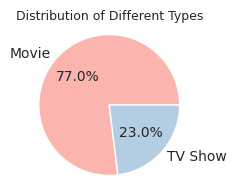

In [180]:
# Distribution of Different Types

# Calculate the counts of each type
type_counts = data['type'].value_counts()
print(type_counts,"\n\n")

# Plotting a pie chart
plt.figure(figsize=(2,2))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Pastel1'))
plt.title('Distribution of Different Types', fontsize=9)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


**EDA | Feature - Title**

In [183]:
# Unique values in title
print(data['title'].nunique())
print(len(df))

7460
8807


**EDA | Feature - Director**

In [194]:
# Most Productive Director

agg_para = {"show_id": "nunique"}
top_10_movie__director_count = (movie_df
                                .groupby(["director"])
                                .agg(agg_para)
                                .sort_values(by="show_id", ascending=False)
                                )[:10]

top_10_movie__director_count


,show_id
director,
Jan Suter,22
Robert Rodriguez,20
Raúl Campos,20
Rajiv Chilaka,19
Steve Brill,18
Martin Scorsese,18
Anurag Kashyap,17
Jay Karas,15
Peter Spirer,15


In [224]:
import pandas as pd

# Group by director and aggregate show IDs into a comma-separated string
director_show_ids = movie_df.groupby('director')['show_id'].agg(lambda x: ','.join(x.unique())).reset_index()

# Count the unique show IDs for each director
director_show_ids['unique_show_id_count'] = director_show_ids['show_id'].apply(lambda x: len(x.split(',')))

# Sort the DataFrame by unique_show_id_count in descending order
director_show_ids_sorted = director_show_ids.sort_values(by='unique_show_id_count', ascending=False)

# Display the top 10 rows
director_show_ids_sorted.head(10)


,director,show_id,unique_show_id_count
1640,Jan Suter,"s4750,s4782,s4809,s4850,s4867,s4941,s4963,s500...",22
3383,Robert Rodriguez,"s864,s1495,s1665,s2928,s3173,s3443,s3581,s4138...",20
3271,Raúl Campos,"s4750,s4782,s4809,s4850,s4867,s4941,s4963,s500...",20
3223,Rajiv Chilaka,"s407,s408,s409,s410,s411,s412,s413,s414,s415,s...",19
3791,Steve Brill,"s265,s976,s1158,s1554,s1880,s2928,s3443,s3581,...",18
2525,Martin Scorsese,"s976,s1359,s2633,s2861,s3228,s3713,s3760,s4138...",18
351,Anurag Kashyap,"s999,s1674,s1679,s2268,s2421,s3061,s3197,s4466...",17
1681,Jay Karas,"s2696,s3647,s3734,s4804,s4864,s5087,s5231,s562...",15
3099,Peter Spirer,"s171,s1933,s2385,s2690,s3182,s3536,s4241,s4547...",15
2463,Marcus Raboy,"s2850,s3636,s3777,s3878,s4315,s4789,s4852,s502...",15


In [226]:
import pandas as pd

# Assuming the 'release_year' column exists in your DataFrame 'movie_df'
# Convert 'release_year' to datetime if it's not already in datetime format
movie_df['release_year'] = pd.to_datetime(movie_df['release_year'])

# Group by director and aggregate show IDs into a comma-separated string
director_show_ids = movie_df.groupby('director')['show_id'].agg(lambda x: ','.join(x.unique())).reset_index()

# Count the unique show IDs for each director
director_show_ids['unique_show_id_count'] = director_show_ids['show_id'].apply(lambda x: len(x.split(',')))

# Calculate min and max release years for each director's work
director_show_ids['min_release_year'] = movie_df.groupby('director')['release_year'].transform('min').dt.year
director_show_ids['max_release_year'] = movie_df.groupby('director')['release_year'].transform('max').dt.year

# Calculate the range of active years
director_show_ids['active_years'] = director_show_ids['max_release_year'] - director_show_ids['min_release_year']

# Sort the DataFrame by unique_show_id_count in descending order
director_show_ids_sorted = director_show_ids.sort_values(by='unique_show_id_count', ascending=False)

# Display the top 10 rows
director_show_ids_sorted.head(10)


<ipython-input-226-fb49588c046c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['release_year'] = pd.to_datetime(movie_df['release_year'])


,director,show_id,unique_show_id_count,min_release_year,max_release_year,active_years
1640,Jan Suter,"s4750,s4782,s4809,s4850,s4867,s4941,s4963,s500...",22,2006.0,2006.0,0.0
3383,Robert Rodriguez,"s864,s1495,s1665,s2928,s3173,s3443,s3581,s4138...",20,2007.0,2007.0,0.0
3271,Raúl Campos,"s4750,s4782,s4809,s4850,s4867,s4941,s4963,s500...",20,1988.0,2020.0,32.0
3223,Rajiv Chilaka,"s407,s408,s409,s410,s411,s412,s413,s414,s415,s...",19,1990.0,2001.0,11.0
3791,Steve Brill,"s265,s976,s1158,s1554,s1880,s2928,s3443,s3581,...",18,2018.0,2018.0,0.0
2525,Martin Scorsese,"s976,s1359,s2633,s2861,s3228,s3713,s3760,s4138...",18,1993.0,2009.0,16.0
351,Anurag Kashyap,"s999,s1674,s1679,s2268,s2421,s3061,s3197,s4466...",17,2021.0,2021.0,0.0
1681,Jay Karas,"s2696,s3647,s3734,s4804,s4864,s5087,s5231,s562...",15,2004.0,2004.0,0.0
3099,Peter Spirer,"s171,s1933,s2385,s2690,s3182,s3536,s4241,s4547...",15,1999.0,2003.0,4.0
2463,Marcus Raboy,"s2850,s3636,s3777,s3878,s4315,s4789,s4852,s502...",15,NaN,NaN,NaN


In [241]:
# Filter the DataFrame for movies directed by "Jan Suter" and select relevant columns
dum = movie_df[movie_df["director"] == "Jan Suter"][["show_id", "release_year"]]

# Find the earliest release year for "Jan Suter"
earliest_year = dum["release_year"].min()
lastest_year = dum["release_year"].max()

# Filter the DataFrame for movies directed by "Jan Suter" in the earliest release year
earliest_year_movies = dum[dum["release_year"] == earliest_year]
latest_year_movies = dum[dum["release_year"] == lastest_year]
# Count the unique show_id values for the earliest release year
# earliest_year_movies #2016
# latest_year_movies #2018



,show_id,release_year
110554,s4750,2018-07-01
110555,s4750,2018-07-01
111142,s4782,2018-07-01
111642,s4809,2018-07-01
112376,s4850,2018-07-01
112714,s4867,2018-07-01
114189,s4941,2018-07-01
114743,s4963,2018-07-01
115791,s5002,2018-07-01
115793,s5003,2018-07-01


In [204]:
data.colu

Index(['show_id', 'title', 'director', 'cast', 'listed_in', 'country', 'type',
       'date_added', 'release_year', 'rating', 'duration', 'description',
       'movie_duration', 'num_of_seasons', 'target_ages', 'month_added'],
      dtype='object')

In [156]:
# import pandas as pd

# director_mapping_data = merged_df[['director', 'cast', 'listed_in', 'country', 'type']].copy()

# director_mapping_data.dropna(subset=['director', 'cast', 'listed_in', 'country', 'type'], inplace=True)

# director_mapping_data.drop_duplicates(inplace=True)

# director_mapping_data.shape

# **ABC**

In [157]:
data_quality_statistics(df)

,Column,Number of Rows,Number of Unique Values,Number of NaN,Percentage of NaN,Data Type
0,show_id,8807,8807,0,0.00,object
1,type,8807,2,0,0.00,object
2,title,8807,8807,0,0.00,object
3,director,8807,4528,2634,29.91,object
4,cast,8807,7692,825,9.37,object
5,country,8807,748,831,9.44,object
6,date_added,8807,1714,10,0.11,object
7,release_year,8807,74,0,0.00,datetime64[ns]
8,rating,8807,17,4,0.05,object
9,duration,8807,220,3,0.03,object


In [158]:
missing_values = df.isnull()
tidy = df.loc[~missing_values.any(axis=1)]
miss = df.loc[missing_values.any(axis=1)]

In [159]:
tidy.shape

(5332, 12)

In [160]:
miss.shape

(3475, 12)

In [161]:
missing_values = df.isnull()
tidy = df.loc[~missing_values.any(axis=1)]
miss = df.loc[missing_values.any(axis=1)]

print(tidy.shape[0]) # No NaN in any Rows
print(miss.shape[0]) # At least 1 NaN in all Rows

5332
3475


In [162]:
data_quality_statistics(miss)

,Column,Number of Rows,Number of Unique Values,Number of NaN,Percentage of NaN,Data Type
0,show_id,3475,3475,0,0.00,object
1,type,3475,2,0,0.00,object
2,title,3475,3475,0,0.00,object
3,director,3475,724,2634,75.80,object
4,cast,3475,2551,825,23.74,object
5,country,3475,255,831,23.91,object
6,date_added,3475,1159,10,0.29,object
7,release_year,3475,54,0,0.00,datetime64[ns]
8,rating,3475,16,4,0.12,object
9,duration,3475,167,3,0.09,object


In [163]:
# from the above "data_quality_statistics" we can obsere there are 225 unique coutries, which is leading to suspison.

url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv"
df = pd.read_csv(url)

df["country"].unique()[:100] #..Code(1)
# df["country"].value_counts() #..Code(2)

# we can see issues like
      # nan
      # 'United States' , 'United States, and United States'
      # Extra whitespace
      #  Some entries have multiple countries listed together separated by commas, example "Mexico, United States, Spain, Colombia" , "France, Senegal, Belgium" etc



array(['United States', 'South Africa', nan, 'India',
       'United States, Ghana, Burkina Faso, United Kingdom, Germany, Ethiopia',
       'United Kingdom', 'Germany, Czech Republic', 'Mexico', 'Turkey',
       'Australia', 'United States, India, France', 'Finland',
       'China, Canada, United States',
       'South Africa, United States, Japan', 'Nigeria', 'Japan',
       'Spain, United States', 'France', 'Belgium',
       'United Kingdom, United States', 'United States, United Kingdom',
       'France, United States', 'South Korea', 'Spain',
       'United States, Singapore', 'United Kingdom, Australia, France',
       'United Kingdom, Australia, France, United States',
       'United States, Canada', 'Germany, United States',
       'South Africa, United States', 'United States, Mexico',
       'United States, Italy, France, Japan',
       'United States, Italy, Romania, United Kingdom',
       'Australia, United States', 'Argentina, Venezuela',
       'United States, United Kin

In [164]:
import pandas as pd

url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv"
df = pd.read_csv(url)

df["country"] = df["country"].fillna("").astype(str)
a=sorted(df["country"].unique())[:100]
print(len(df['country'].unique()))
# Split entries with multiple countries into separate rows
df['country'] = df['country'].str.split(', ')
df = df.explode('country')

# Clean up country names
# The 'explode' function splits entries with multiple countries into separate rows.
# For example, if a row originally had 'United States, Canada', it would become two rows,
# one with 'United States' and another with 'Canada'.
# The 'split' function splits the string on commas, creating a list of countries.
# Then, 'explode' converts each item in the list into a separate row.
# This is necessary because each row should represent only one country.

# The following lines would strip leading and trailing whitespaces from country names.
# However, it seems that the data already has clean country names, so this step is unnecessary.
# df['country'] = df['country'].str.strip()

# Now, let's get the unique country names
# print(len(df['country'].unique()))

# df["country"] = df["country"].fillna("").astype(str)
# sorted(df["country"].unique())[:100]
# df["country"].value_counts() #..Code(2)\
# df["country"].isna()
a[:10]

749


['',
 ', France, Algeria',
 ', South Korea',
 'Argentina',
 'Argentina, Brazil, France, Poland, Germany, Denmark',
 'Argentina, Chile',
 'Argentina, Chile, Peru',
 'Argentina, France',
 'Argentina, France, United States, Germany, Qatar',
 'Argentina, Italy']

In [165]:
df.show_id.nunique()

8807

In [166]:
# Country Specific Type --->
# Country Specific Listed-in (Genre) --->
# Evolution of kind of Movies/TV Series Change ---> rank fo each movie/tv-series change w.r.t release_year --->
# Evolution of duration of Movies Series Change --->
# In which month the movies are released, and it going well ---> Trend Analysis. --->
# Most Casted Actor   --->
# Productive Director --->  no, of movies/ range of timeframe
#
# Cast = Actor



In [167]:
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv"
df = pd.read_csv(url)


mask = (df["director"].isna() & df["country"].isna())
df[mask].shape

(409, 12)

In [168]:
mask = (df["cast"].isna() & df["country"].isna())
df[mask].shape

(154, 12)

In [169]:
mask = (df["cast"].isna() & df["director"].isna() & df["country"].isna())
df[mask].shape

# observation 96 rows have - unfillable rows

(96, 12)

In [170]:
96/8807*100


1.0900420120358805

In [171]:
#  0   show_id       8807 non-null   object
#  1   type          8807 non-null   object
#  2   title         8807 non-null   object
#  3   director      6173 non-null   object
#  4   cast          7982 non-null   object
#  5   country       7976 non-null   object
#  6   date_added    8797 non-null   object
#  7   release_year  8807 non-null   int64
#  8   rating        8803 non-null   object
#  9   duration      8804 non-null   object
#  10  listed_in     8807 non-null   object
#  11  description   8807 non-null   object

df['director'] = (df['director']
                  .replace('nan', pd.NA)
                  .apply(lambda x: str(x).split(', ') if pd.notna(x) else [pd.NA])
                  )

# Explode the DataFrame to separate each director into its own row
unnested_dir_df = (df[["show_id","title","director"]]
                   .explode('director')
                   .reset_index(drop=True)
                   )


In [172]:
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv"
df = pd.read_csv(url)

mask = (df["cast"].isna()
          & df["director"].isna()
          & df["country"].isna()
          & df["listed_in"].isna())

df[mask].shape


# observation 0 rows have

(0, 12)

In [173]:
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv"
df = pd.read_csv(url)

df['listed_in'] = (df['listed_in']
                  .replace('nan', pd.NA)
                  .apply(lambda x: str(x).split(', ') if pd.notna(x) else [pd.NA])
                  )

newdf=df[["director","listed_in","country"]][df["director"].isna()]

newdf.explode("listed_in")[:20]

,director,listed_in,country
1,NaN,International TV Shows,South Africa
1,NaN,TV Dramas,South Africa
1,NaN,TV Mysteries,South Africa
3,NaN,Docuseries,NaN
3,NaN,Reality TV,NaN
4,NaN,International TV Shows,India
4,NaN,Romantic TV Shows,India
4,NaN,TV Comedies,India
10,NaN,Crime TV Shows,NaN
10,NaN,Docuseries,NaN


In [174]:
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv"
df = pd.read_csv(url)

df['listed_in'] = (df['listed_in']
                  .replace('nan', pd.NA)
                  .apply(lambda x: str(x).split(', ') if pd.notna(x) else [pd.NA])
                  )

comb_df = (df[["show_id","director","country","listed_in"]]
                   .explode('listed_in')
                   .reset_index(drop=True)
                   )
# Romantic TV Shows	India
# 8740	NaN	British TV Shows	United Kingdom
mask2 = ((comb_df["listed_in"] == "Romantic TV") & (comb_df["country"] == "India") & (~comb_df["director"].isna()))
comb_df[mask2].value_counts()

Series([], Name: count, dtype: int64)

In [175]:
# checking that "NAN" 96 rows


url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv"
df = pd.read_csv(url)

mask3 = (df["cast"].isna() & df["director"].isna() & df["country"].isna())
df[mask3][:5]


# df[mask3].shape

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
10,s11,TV Show,"Vendetta: Truth, Lies and The Mafia",NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, Docuseries, International TV S...","Sicily boasts a bold ""Anti-Mafia"" coalition. B..."
14,s15,TV Show,Crime Stories: India Detectives,NaN,NaN,NaN,"September 22, 2021",2021,TV-MA,1 Season,"British TV Shows, Crime TV Shows, Docuseries",Cameras following Bengaluru police on the job ...
74,s75,TV Show,The World's Most Amazing Vacation Rentals,NaN,NaN,NaN,"September 14, 2021",2021,TV-PG,2 Seasons,Reality TV,"With an eye for every budget, three travelers ..."
123,s124,TV Show,Luv Kushh,NaN,NaN,NaN,"September 2, 2021",2012,TV-Y7,1 Season,Kids' TV,"Based on the last book of the epic Ramayana, t..."


In [176]:
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv"
df = pd.read_csv(url)

# df[["director","country"]][~df.director.isna() & df.country.isna()][:10]

# count_df = (df
#             .groupby(["director", "country"])
#             .size()
#             .reset_index(name='count'))

# count_df


# ---

count_df = (df
            .groupby(["director", "country"]) #.size()
            ).value_counts()

# count_df
# dir_country_main = count_df.loc[count_df.groupby('director')['count'].idxmax()].reset_index(drop=True)
# dir_country_main[:2]

In [177]:
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv"
df = pd.read_csv(url)

# from : dir_country_main
# to : df

filled_director_df = pd.merge(df,
                              dir_country_main,
                              on = "director",
                              how = "left" )

filled_director_df = filled_director_df.drop("country_x", axis = 1)
filled_director_df[:10]

filled_director_df[["director", "country_y"]][df["country"].isna()]


NameError: name 'dir_country_main' is not defined

In [ ]:
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv"
df = pd.read_csv(url)

df['listed_in'] = (df['listed_in']
                  .replace('nan', pd.NA)
                  .apply(lambda x: str(x).split(', ') if pd.notna(x) else [pd.NA])
                  )

comb_df = (df[["show_id","director","country","listed_in"]]
                   .explode('listed_in')
                   .reset_index(drop=True)
                  )
